In [298]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.axisartist.axislines import SubplotZero

import math

In [299]:
def setUniformDistribution(step):
    return np.full(step + 1, 1/step)

In [300]:
def getLikelihood(result, step):
    if result == "完走":
        return [1/step * i for i in range(step+1)]
    elif result == "失敗":
        return [1-(1/step * i) for i in range(step+1)]
        

In [301]:
def normalize(poster_dist):
    norm_const = 1/sum(poster_dist)
    return norm_const * poster_dist

In [302]:
def getPosteriorDistribution(likelihood, prior_dist):
    return likelihood * prior_dist

In [303]:
def getStdev(mean, poster_dist, prob):
    return math.sqrt(sum([po*pow(pr, 2)
                         for (po, pr) in zip(poster_dist, prob)]) - pow(mean, 2))

In [304]:
def splitData(results_list):
    result = []
    results = []
    for r in results_list:
        if r == "," or r == "\n":
            results.append(result[:])
            result.clear()
            continue
        result.append(r)
    results.append(result)
    return results

In [305]:
def checkData(results_list):
  for results in results_list:
      for result in results:
        if not(result=="完走" or result=="失敗"):
          raise ValueError("引数として、'完走'か'失敗'、区切りのための','のみしか受け付けていません")

In [306]:
def plot(poster_dists, prob, step):
    fig = plt.figure(figsize = (12,6))
    ax = SubplotZero(fig, 111)
    fig.add_subplot(ax)

    for poster_dist , idx in zip(poster_dists, range(len(poster_dists))):
        prob_mean = sum([po*pr for (po, pr) in zip(poster_dist, prob)])
        prob_stdev = getStdev(prob_mean, poster_dist, prob)
        prob_stdev_min = prob_mean - prob_stdev
        prob_stdev_max = prob_mean + prob_stdev
        if prob_stdev_min < 0:
            prob_stdev_min = 0
        if prob_stdev_max > 1:
            prob_stdev_max = 1

        ax.bar(prob, poster_dist, width=1/step, edgecolor="black", alpha=0.6)
        ax.text(prob_mean - 0.025,
                np.max(poster_dist)*2.03, "平均", size=20)
        ax.plot([[prob_mean]for i in range(2)],
                [0, np.max(poster_dist)*2], lw=2, color="r")
        ax.fill_between([prob_stdev_min, prob_stdev_max],
                        [0, 0],
                        [np.max(poster_dist)*2, np.max(poster_dist)*2], alpha=0.2, color='red')
        ax.text(prob_mean-0.06, np.max(poster_dist)*1.53, "標準偏差", size=20)
        ax.annotate('',
                    xy=[prob_stdev_min, np.max(poster_dist)*1.5],
                    xytext=[prob_stdev_max, np.max(poster_dist)*1.5],
                    arrowprops=dict(arrowstyle='<|-|>',
                                    connectionstyle='arc3',
                                    facecolor='C0',
                                    edgecolor='C0'))
        if(idx == 0):
          ax.text(prob_mean-0.05, np.max(poster_dist)*2.03 +0.015, "改良前", size=25)
        else:
          ax.text(prob_mean-0.05, np.max(poster_dist)*2.03 +0.015, "改良後", size=25)
        fig.add_subplot(ax)

    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(0.0, 0.2)
    for direction in ["right", "top"]:
        ax.axis[direction].set_visible(False)
    for direction in ["left",  "bottom"]:
        ax.axis[direction].set_axisline_style("-|>")
    ax.grid(which='major', color='black')
    ax.grid(which='minor', color='gray', linestyle='--')
    ax.tick_params(labelsize=30)
    ax.set_xlabel("完走率", fontname='IPAGothic', fontsize=50)
    ax.set_ylabel("確率", fontname='IPAGothic', fontsize=50)
    plt.show()

In [307]:
step = 100
results_data =["完走", "失敗", "失敗", "完走", "完走", ",",  "完走", "完走", "完走", "完走", "完走"] #改良前、改良後
prob = [1/step * i for i in range(step+1)]

prior_dist = np.array([])
poster_dist = np.array([])
poster_dist_list = []
likelihood = np.array([])

results_list = splitData(results_data)
try:
  checkData(results_list)
except ValueError as e:
    print(e)
    exit(1)

In [308]:
for results in results_list:
    prior_dist = setUniformDistribution(step)
    for result in results:
        likelihood = getLikelihood(result, step)
        poster_dist = getPosteriorDistribution(likelihood, prior_dist)
        poster_dist = normalize(poster_dist)
        prior_dist = poster_dist
    poster_dist_list.append(poster_dist.tolist())

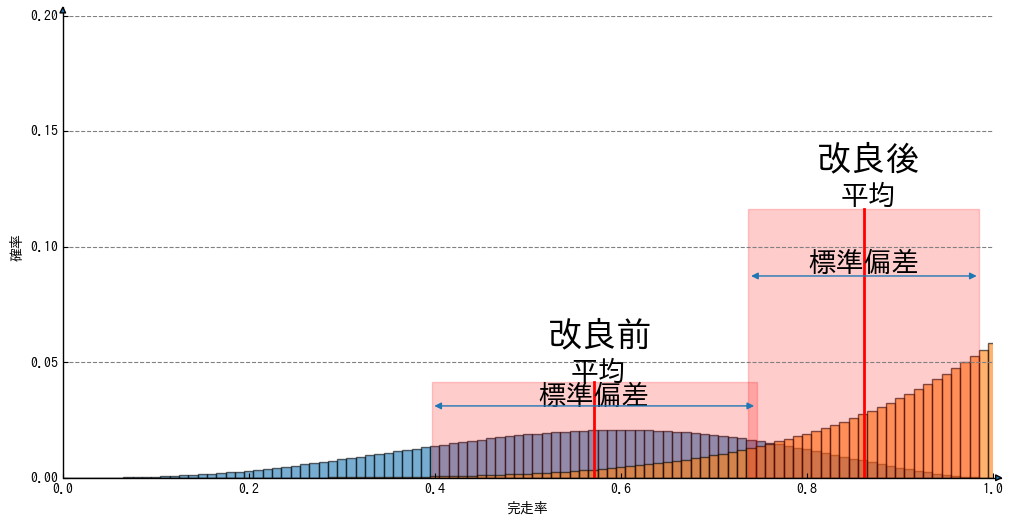

In [309]:
plot(poster_dist_list, prob, step)
